# Capstone 2: Correlating Wikipedia traffic with news events
### Jonas Cuadrado

## Part 3: Topic modelling

Here, we will upload the saved data from the previous two parts and perform different topic modelling approaches to optimeize the topic selection. We will also try to reach conclusions here

In [1]:
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
import requests
import json
import pandas as pd
from datetime import datetime
import gzip
import io
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
# read the data

newsarts = pd.read_csv('Selectedarticles.csv')
wikiarts = pd.read_csv('Wikipediaarticles.csv')


In [3]:
nlpdf = pd.concat([newsarts[['title','publication','date','content']],wikiarts[['title','publication','date','content']]], ignore_index=True)
nlpdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10181 entries, 0 to 10180
Data columns (total 4 columns):
title          10181 non-null object
publication    10181 non-null object
date           10181 non-null object
content        10181 non-null object
dtypes: object(4)
memory usage: 318.2+ KB


In [4]:
# parse dates!
nlpdf['date']=pd.to_datetime(nlpdf['date'])
nlpdf.head()

Now, let's perform NLP on this dataset. I want to have everything saved for now (publisher, data, ...) as we will do some cool visualizations later.

Ideas: 
* What's the topic distribution per media source?
* What articles are the closest to those by wikipedia? Plot a timeline of the correlation
* What came first? wiki traffic or news? Probably wiki traffic...

For the NLP, I want to:
* Remove stopwords and numbers [outside what's in the package]
* Consider LDA, NMF, and perhaps more?
* Consider timing
* Consider runtime
* Topic coherence as a measure.
* I want to see if 'deaths' are a topic...

For the visualizations, I want to do word clouds of the outputs, and see if we find anything interesting in the data.

As a conclusion, we will see... but essentially decide if we want to deploy more servers under specific conditions, or move the data to a hotter storage...

In [5]:
# here we could integrate stopwords 

global stopwords 
stopwords = ["a","able","about","above","according","accordingly","applause","across","actually","after",
                    "afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already",
                    "also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow",
                    "anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are",
                    "aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","be",
                    "became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe",
                    "below","beside","besides","best","better","between","beyond","both","brief","but","by","c'mon","c's",
                    "came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co",
                    "com","come","comes","concerning","consequently","consider","considering","contain","containing",
                    "contains","corresponding","could","couldn't","course","currently","definitely","described","despite",
                    "did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during",
                    "each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc",
                    "even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except",
                    "far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth",
                    "four","from","further","furthermore","get","gets","getting","given","gives","go","goes","going","gone",
                    "got","gotten","greetings","had","hadn't","happens","hardly","has","hasn't","have","haven't","having",
                    "he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers",
                    "herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll",
                    "i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated",
                    "indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its",
                    "itself","just","keep","keeps","kept","know","known","knows","last","lately","later","latter","latterly",
                    "least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd",
                    "mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly",
                    "much","must","my","myself","name","namely","nd","near","nearly","necessary","need","needs","neither",
                    "never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not",
                    "nothing","novel","now","nowhere","obviously","of","off","often","oh","ok","okay","old","on","once",
                    "one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out",
                    "outside","over","overall","own","particular","particularly","per","perhaps","placed","please","plus",
                    "possible","presumably","probably","provides","que","quite","qv","rather","rd","re","really","reasonably",
                    "regarding","regardless","regards","relatively","respectively","right","said","same","saw","say","saying",
                    "says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves",
                    "sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since",
                    "six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat",
                    "somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t's",
                    "take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their",
                    "theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore",
                    "therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third",
                    "this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to",
                    "together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","un",
                    "under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses",
                    "using","usually","value","various","very","via","viz","vs","want","wants","was","wasn't","way","we",
                    "we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever",
                    "when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon",
                    "wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why",
                    "will","willing","wish","with","within","without","won't","wonder","would","wouldn't","yes","yet","you",
                    "you'd","you'll","you're","you've","your","yours","yourself","yourselves","zero"]

In [6]:
#and numbers! What I want to do is go word by word. 
# If len(word)<3, drop it
# If it's a number, drop it
# If it's on the list of stopwords, also drop it

def customprecleaning(string):
    """Drop words with less than 3 chars, drop numbers, drop words from stopword list"""
    wrds = string.split(' ')
    newwrds = ''
    for wrd in wrds:
        wrd = wrd.lower()
        if (not wrd.isdigit()) and (wrd not in stopwords) and (len(wrd)>2):
            newwrds = newwrds + wrd + ' '
    return(newwrds)

In [7]:
nlpdf['content']=nlpdf['content'].apply(customprecleaning)
nlpdf.head()

In [8]:
# for later...
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [9]:
n_samples = 10181
n_features = 350
n_components = 15 # tis the number of topics
n_top_words = 10

data_samples = nlpdf['content'].tolist()[:n_samples]

In [10]:
# topic modelling 1: NMF with KL divergence
t0 = time()

print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.1,
                                   max_features=n_features,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("Features extracted in %0.3fs." % (time() - t0))

print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

t0 = time()

nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("Fit done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Extracting tf-idf features for NMF...
Features extracted in 4.682s.
Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=10181 and n_features=350...
Fit done in 19.320s.

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: time years called year long day asked told days past
Topic #1: trump campaign donald presidential republican clinton candidate president hillary election
Topic #2: police killed man told people officials night state released left
Topic #3: government president state washington officials wednesday year statement states reporting
Topic #4: don make time people life good things didn work thing
Topic #5: company billion year business percent million market chief companies wednesday
Topic #6: case court law federal justice legal public order office asked
Topic #7: percent americans country states recent large national america american people
Topic #8: united women states trump american countries men world cou

In [12]:
# LDA.
t0 = time()

print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=0.1,
                                max_features=n_features,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(data_samples)
print("Features extracted in %0.3fs." % (time() - t0))
print()

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

t0 = time()

lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(tf)
print("Fit done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Extracting tf features for LDA...
Features extracted in 4.432s.

Fitting LDA models with tf features, n_samples=10181 and n_features=350...
Fit done in 42.831s.

Topics in LDA model:
Topic #0: united states american world country war countries america international national
Topic #1: trump donald campaign republican presidential election voters candidate percent support
Topic #2: trump president obama administration white house washington office policy security
Topic #3: women health people data care research work public program university
Topic #4: police death school center family university children march year man
Topic #5: percent company million year billion companies business market money financial
Topic #6: clinton hillary campaign democratic state obama election presidential president secretary
Topic #7: told city officials people statement state friday thursday reported cnn
Topic #8: time work years people don world make day life year
Topic #9: house republicans congress repub

How are these topics meaningful? Can we chose between an approach or the other?

In [13]:
coheach = []
for topic_idx, topic in enumerate(lda.components_):
    topwordlist = topic.argsort()[:-n_top_words - 1:-1]
    listofpariwisesims = []
    for pair in combinations(topwordlist, 2):
        listofpariwisesims.append(cosine_similarity(tf[:,pair[0]].T,tf[:,pair[1]].T)[0][0])
    coheach.append(np.mean(listofpariwisesims))
    
print('LDA coherence', np.mean(coheach))


coheach = []
for topic_idx, topic in enumerate(nmf.components_):
    topwordlist = topic.argsort()[:-n_top_words - 1:-1]
    listofpariwisesims = []
    for pair in combinations(topwordlist, 2):
        listofpariwisesims.append(cosine_similarity(tfidf[:,pair[0]].T,tfidf[:,pair[1]].T)[0][0])
    coheach.append(np.mean(listofpariwisesims))
    
print('NMF-KL coherence', np.mean(coheach))

LDA coherence 0.3346707527654362
NMF-KL coherence 0.21222076244976956


As expected, LDA outperforms NMF, so let's try to find the optimal number of topics, and features:

In [14]:
# instead of doing a gridsearch, let's do 2 fors...
coherences = {}
bestcoh = 0.0

for nfeats in [20,50,100,200,500]: 
    for ntopics in [15,20,25,30,35,40]:
        print('Starting ', nfeats, ' features with ', ntopics, ' topics')
        tf_vectorizer = CountVectorizer(max_df=0.95, min_df=0.1,
                                max_features=nfeats,
                                stop_words='english')
        
        tf = tf_vectorizer.fit_transform(data_samples)
        
        lda = LatentDirichletAllocation(n_components=ntopics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
        lda.fit(tf)
        
        coheach = []
        for topic_idx, topic in enumerate(lda.components_):
            topwordlist = topic.argsort()[:-n_top_words - 1:-1]
            listofpariwisesims = []
            for pair in combinations(topwordlist, 2):
                listofpariwisesims.append(cosine_similarity(tf[:,pair[0]].T,tf[:,pair[1]].T)[0][0])
            coheach.append(np.mean(listofpariwisesims))
        
        coherences[(nfeats,ntopics)] = np.mean(coheach)
        if np.mean(coheach) > bestcoh:
            bestcoh = np.mean(coheach)
            bestparams = (nfeats,ntopics)

#
print('Best coherence:', bestcoh)
print('Best parameters:', bestparams)

Starting  20  features with  15  topics
Starting  20  features with  20  topics
Starting  20  features with  25  topics
Starting  20  features with  30  topics
Starting  20  features with  35  topics
Starting  20  features with  40  topics
Starting  50  features with  15  topics
Starting  50  features with  20  topics
Starting  50  features with  25  topics
Starting  50  features with  30  topics
Starting  50  features with  35  topics
Starting  50  features with  40  topics
Starting  100  features with  15  topics
Starting  100  features with  20  topics
Starting  100  features with  25  topics
Starting  100  features with  30  topics
Starting  100  features with  35  topics
Starting  100  features with  40  topics
Starting  200  features with  15  topics
Starting  200  features with  20  topics
Starting  200  features with  25  topics
Starting  200  features with  30  topics
Starting  200  features with  35  topics
Starting  200  features with  40  topics
Starting  500  features with

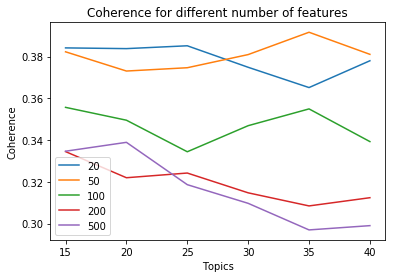

In [15]:
dfcoh=pd.DataFrame.from_dict(coherences, orient='index')
# put index in column
dfcoh = dfcoh.reset_index()
# break column into 2 columns
dfcoh[['Features','Topics']] = pd.DataFrame(dfcoh['index'].values.tolist(), index= dfcoh.index)
# rename and keep just some stuff
dfcoh = dfcoh.rename(index=str, columns={0: "Coherence"})
dfcoh = dfcoh[['Features','Topics','Coherence']]
# plot stuff!
for feat in dfcoh['Features'].unique().tolist():
    sns.lineplot(data=dfcoh[dfcoh['Features']==feat], x='Topics', y='Coherence')

plt.legend(dfcoh['Features'].unique().tolist())
plt.title('Coherence for different number of features')
plt.show()


In [20]:
t0 = time()

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=0.1,
                                max_features=bestparams[0],
                                stop_words='english')

tf = tf_vectorizer.fit_transform(data_samples)


t0 = time()

lda = LatentDirichletAllocation(n_components=bestparams[1], max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(tf)
print("Fit done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Fit done in 23.805s.

Topics in LDA model:
Topic #0: campaign times political including trump people government time make told
Topic #1: trump president donald house campaign government national political time obama
Topic #2: news work times people good american including told president week
Topic #3: clinton campaign state election time trump president national donald party
Topic #4: week president time years day national people long told public
Topic #5: state states year people group years time week political including
Topic #6: good american day donald work police national years women public
Topic #7: country year public long president called political years including american
Topic #8: world years life work public including called time long make
Topic #9: group national public including government year political president time called
Topic #10: people work years time life make don called long group
Topic #11: washington national years life york public people told states country
To

There is little difference, but let's look at the 35 topics

Once we have the best model, let's try to fit things and draw stuff. We want:

* What are the topics for the wikipedia articles?
* How are the wikipedia articles correlated to the others (in date)? What comes first?
* Repeat topic modelling for the wikipedia files only, see how changes with any of the global topics. How close are the wikipedia articles to media?

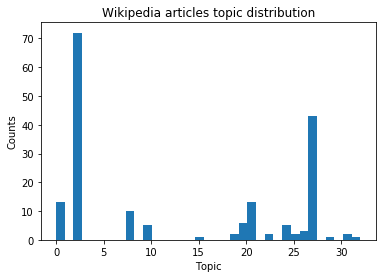

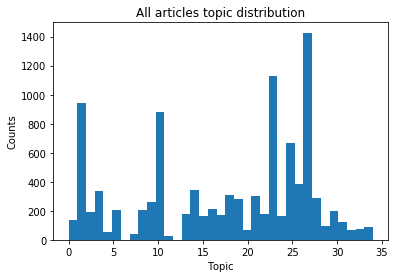

In [28]:
# probability distribution of wikipedia topics
probdisttopics = []
for art in tf[10000:10181]:
    doc_topic = lda.transform(art)
    probdisttopics.append(doc_topic.argmax())

# now I want to plot the distribution of this... so, a histogram
plt.hist(probdisttopics, bins=35)
plt.title('Wikipedia articles topic distribution')
plt.xlabel('Topic')
plt.ylabel('Counts')
plt.show()

probdisttopics = []
for art in tf:
    doc_topic = lda.transform(art)
    probdisttopics.append(doc_topic.argmax())
    
plt.hist(probdisttopics, bins=35)
plt.title('All articles topic distribution')
plt.xlabel('Topic')
plt.ylabel('Counts')
plt.show()

Most of the articles in wikipedia are of topics 0,2,21, and 27:

* Topic #0: campaign times political including trump people government time make told
* Topic #2: news work times people good american including told president week
* Topic #21: states united president country including world american work year make
* Topic #27: year time years work life long called make day including

While in general, most articles are topics 1, 10, 23 and 27:

* Topic #1: trump president donald house campaign government national political time obama
* Topic #10: people work years time life make don called long group
* Topic #23: trump donald republican campaign don people make called york told
* Topic #27: year time years work life long called make day including

In general, it seems the wikipedia articles are not exclusive in topics, which means we can try to correlate the two datasets.

If I had to guess, I'd say topic 27 is for people passing away, like Rickman or Scalia. Let's see if that's the case.

In [22]:
famousdeaths = nlpdf.iloc[[10006,10008,10016]]['title'].tolist()
print('Some wikipedia articles about people:', famousdeaths)

# let's take articles with index 6,8, and 16
# which means that they are 10007,10009 and 10017 in tf

listofarts = [10006,10008,10016]

for art in listofarts:
    doc_topic = lda.transform(tf[art])
    print('Topic for: ', nlpdf.iloc[art]['title'], ' : ', doc_topic.argmax())

Some wikipedia articles about people: ['David_Bowie', 'Alan_Rickman', 'Antonin_Scalia']
Topic for:  David_Bowie  :  2
Topic for:  Alan_Rickman  :  2
Topic for:  Antonin_Scalia  :  22


Well, it seems it's topic 2 associated with deaths... Scalia is associated mostly with 24 becuase of his supreme court association, but probably topic 2 is high (?)


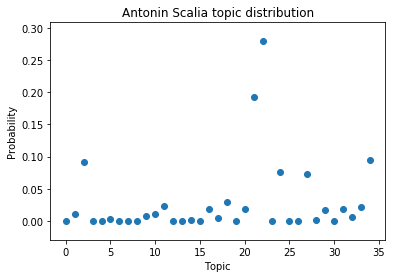

In [23]:
doc_topic = lda.transform(tf[10016])
plt.scatter(np.arange(len(doc_topic[0])), doc_topic[0])
plt.title('Antonin Scalia topic distribution')
plt.xlabel('Topic')
plt.ylabel('Probability')
plt.show()

Indeed! As he passed away, the wikipedia article reflects that. But since he had such an important public position, topic 22, associated to the State structures, is predominant, as well as topic 21. This means we probably need to look beyong the most important topic to understand the data.

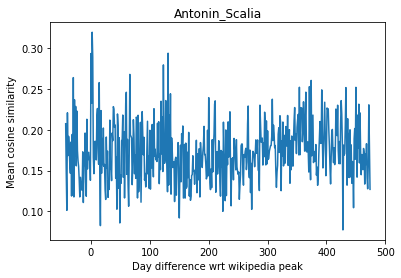

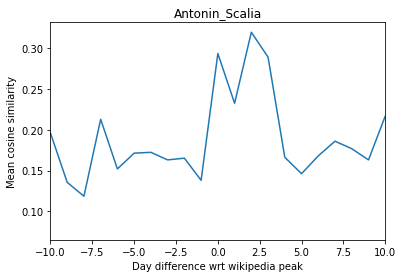

In [24]:
# Let's correlate in time... let me start by doing just 1 of the plots I want. Then, I want to superimpose all of them...

currartidx = 10016

# new dataframe with the date

tdcorr1=pd.DataFrame()
tdcorr1['datedif']= (nlpdf.iloc[:10000]['date'] - nlpdf.iloc[currartidx]['date']).astype('timedelta64[D]')
tdcorr1['index1'] = tdcorr1.index
tdcorr1['coscorr'] = tdcorr1.index1.apply(lambda x: cosine_similarity(tf[x,:],tf[currartidx,:])[0][0])

# plto cosine similarity
sns.lineplot(data=tdcorr1.groupby('datedif').mean()['coscorr'])
plt.title(nlpdf.iloc[currartidx]['title'])
plt.xlabel('Day difference wrt wikipedia peak')
plt.ylabel('Mean cosine similarity')
plt.show()

sns.lineplot(data=tdcorr1.groupby('datedif').mean()['coscorr'])
plt.xlim([-10,10])
plt.title(nlpdf.iloc[currartidx]['title'])
plt.xlabel('Day difference wrt wikipedia peak')
plt.ylabel('Mean cosine similarity')
plt.show()

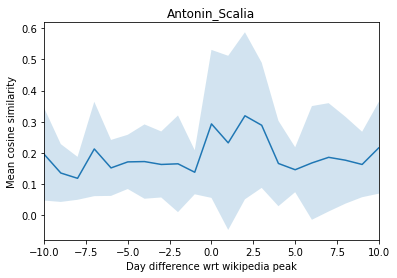

In [25]:
# to add the shade with the std, use fill_between
plt.plot(tdcorr1.groupby('datedif').mean().index, tdcorr1.groupby('datedif').mean()['coscorr'])
plt.fill_between(tdcorr1.groupby('datedif').mean().index, tdcorr1.groupby('datedif').mean()['coscorr']+tdcorr1.groupby('datedif').std()['coscorr'], tdcorr1.groupby('datedif').mean()['coscorr']-tdcorr1.groupby('datedif').std()['coscorr'], alpha=0.2)
plt.xlim([-10,10])
plt.title(nlpdf.iloc[currartidx]['title'])
plt.xlabel('Day difference wrt wikipedia peak')
plt.ylabel('Mean cosine similarity')
plt.show()

There is a clear correlation peak which is delayed! In the case of this article there was a lot of talking about the supreme court replacement in the following days, so it is normal that there is a high similarity for longer times. It seems, however, that articles keep on appearing on the news after the wikipedia peak only, which indicates that a wikipedia peak anounces a higher number of news related to that specific article. Let's explore in depth for all the articles, and the articles per topic...

In [26]:
tdcorr1=pd.DataFrame()
tdcorr1['datedif']= (nlpdf.iloc[:10000]['date'] - nlpdf.iloc[10001]['date']).astype('timedelta64[D]')
tdcorr1['index1'] = tdcorr1.index
tdcorr1['coscorr'] = tdcorr1.index1.apply(lambda x: cosine_similarity(tf[x,:],tf[10001,:])[0][0])
meantdcorrperart = tdcorr1.groupby('datedif').mean()


for currartidx in range(10002,10181):
    tdcorr1=pd.DataFrame()
    tdcorr1['datedif']= (nlpdf.iloc[:10000]['date'] - nlpdf.iloc[currartidx]['date']).astype('timedelta64[D]')
    tdcorr1['index1'] = tdcorr1.index
    tdcorr1[currartidx] = tdcorr1.index1.apply(lambda x: cosine_similarity(tf[x,:],tf[currartidx,:])[0][0])
    meantdcorrperart = pd.concat([meantdcorrperart, tdcorr1.groupby('datedif').mean()[currartidx]], axis=1, join='outer')
    
    #meantdcorrperart[currartidx] = tdcorr1.groupby('datedif').mean()['coscorr']

# drop index1
meantdcorrperart = meantdcorrperart.rename(columns={'coscorr':10001})
meantdcorrperart = meantdcorrperart.drop('index1', axis=1)

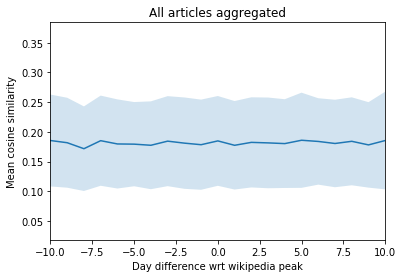

In [29]:
#meantdcorrperart = meantdcorrperart.rename(columns={'coscorr':10001})
xvals = []
yvals = []
evalsplus = []
evalsminus = []
for ind in meantdcorrperart.index.values:
    xvals.append(ind)
    yvals.append(meantdcorrperart.loc[ind].mean())
    evalsplus.append(meantdcorrperart.loc[ind].mean()+meantdcorrperart.loc[ind].std())
    evalsminus.append(meantdcorrperart.loc[ind].mean()-meantdcorrperart.loc[ind].std())
# plot them

plt.plot(xvals,yvals)
plt.fill_between(xvals,evalsplus,evalsminus, alpha=0.2)
plt.xlim([-10,10])
plt.title('All articles aggregated')
plt.xlabel('Day difference wrt wikipedia peak')
plt.ylabel('Mean cosine similarity')
plt.show()

The averages seem to wash it down, but there may be an influence of the topic selected. Let's look at the most meaningful topics and take the articles on them:

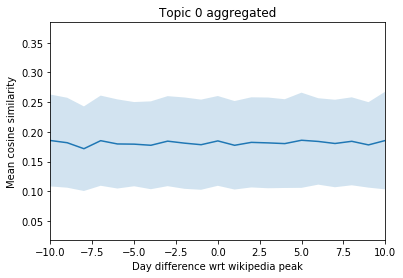

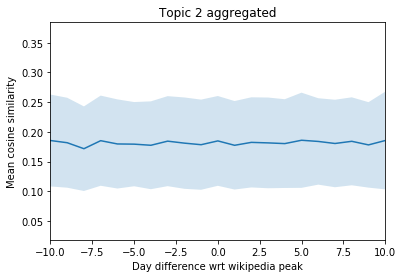

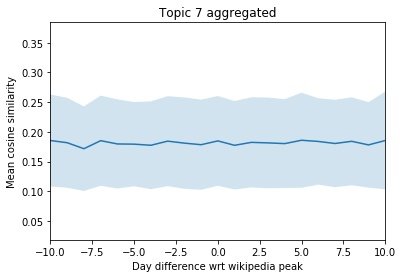

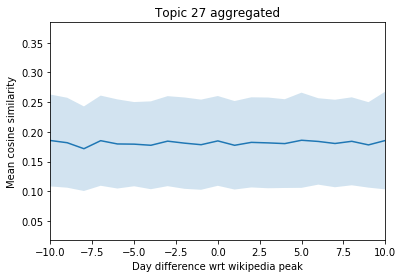

In [30]:
probdisttopics = []
for art in tf[10000:10180]:
    doc_topic = lda.transform(art)
    probdisttopics.append(doc_topic.argmax())
# topics to select: 0,2,8, and 16

for topic in [0,2,7,27]:
    indices = [i for i, x in enumerate(probdisttopics) if x == topic]
    xvals = []
    yvals = []
    evalsplus = []
    evalsminus = []
    for ind in meantdcorrperart.iloc[:,indices].index.values:
        xvals.append(ind)
        yvals.append(meantdcorrperart.loc[ind].mean())
        evalsplus.append(meantdcorrperart.loc[ind].mean()+meantdcorrperart.loc[ind].std())
        evalsminus.append(meantdcorrperart.loc[ind].mean()-meantdcorrperart.loc[ind].std())
    # plot them
    
    plt.plot(xvals,yvals)
    plt.fill_between(xvals,evalsplus,evalsminus, alpha=0.2)
    plt.xlim([-10,10])
    plt.title('Topic '+ str(topic) + ' aggregated')
    plt.xlabel('Day difference wrt wikipedia peak')
    plt.ylabel('Mean cosine similarity')
    plt.show()
    
    

They are consistently washed out. Instead, let's look at what articles show largest mean similarity at 0:

In [31]:
print('Articles with highest media repercussion')
print()

for artsel in meantdcorrperart.pct_change().loc[0].sort_values(ascending=False).head(15).index:
    topichere = lda.transform(tf[artsel]).argmax()
    print(nlpdf.loc[artsel]['title'], '( Topic', topichere, ') --- ', meantdcorrperart.pct_change().loc[0].sort_values(ascending=False).loc[artsel])

Articles with highest media repercussion

Antonin_Scalia ( Topic 22 ) ---  1.122920939911423
Jesus_nut ( Topic 27 ) ---  0.8925623985316848
Pierre_Brassau ( Topic 27 ) ---  0.8270671778995227
José_Fernández_(pitcher) ( Topic 2 ) ---  0.7343471297114634
Merrick_Garland ( Topic 22 ) ---  0.7003123062622494
Mary_(elephant) ( Topic 21 ) ---  0.6654081748011484
Alan_Thicke ( Topic 2 ) ---  0.6176231233540612
Muzdalifah ( Topic 27 ) ---  0.5533614530726585
Leonard_Cohen ( Topic 2 ) ---  0.518054574686845
Fidel_Castro ( Topic 2 ) ---  0.4728181036742789
Nuclear_program_of_Saudi_Arabia ( Topic 2 ) ---  0.4690601092609108
Alexander_Hamilton ( Topic 21 ) ---  0.4311465078836383
Kamehameha_I ( Topic 27 ) ---  0.3973156549749848
Government_Secure_Intranet ( Topic 26 ) ---  0.39625627829111365
VX_(nerve_agent) ( Topic 21 ) ---  0.38009215389085327


In [32]:
print('Articles with lowest media repercussion')
print()

for artsel in meantdcorrperart.pct_change().loc[0].sort_values(ascending=True).head(15).index:
    topichere = lda.transform(tf[artsel]).argmax()
    print(nlpdf.loc[artsel]['title'], '(Topic', topichere, ') --- ', meantdcorrperart.pct_change().loc[0].sort_values(ascending=True).loc[artsel])

Articles with lowest media repercussion

Blendo (Topic 19 ) ---  -0.5472519071287285
George_Michael (Topic 2 ) ---  -0.45409047881495623
Lupe_Fuentes (Topic 2 ) ---  -0.3767248587152442
Tanghulu (Topic 10 ) ---  -0.35018516908178887
Pat_Bowlen (Topic 2 ) ---  -0.3443064372645511
Meldonium (Topic 2 ) ---  -0.33982641428616267
Issus_(genus) (Topic 2 ) ---  -0.33358537786703635
Psychosis (Topic 27 ) ---  -0.3249566356458933
Whale_fall (Topic 27 ) ---  -0.2994812893261487
Alan_Rickman (Topic 2 ) ---  -0.2892498161353291
Web_performance (Topic 27 ) ---  -0.24969376583323144
Lincoln_Logs (Topic 19 ) ---  -0.23811642256339527
GBU-43/B_Massive_Ordnance_Air_Blast (Topic 27 ) ---  -0.23527552957338382
Supersonic_Low_Altitude_Missile (Topic 21 ) ---  -0.21149151908014063
Load_testing (Topic 27 ) ---  -0.20960071971640137


There is not a clear topic dominance either, but it seems that the articles less correlated to media events are less actual. Perhaps the topic is less well defined. Let's compare Scalia to Bluetooth, which is 10105

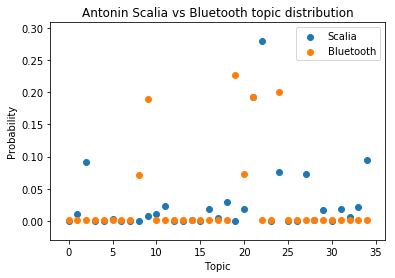

In [33]:
doc_topic1 = lda.transform(tf[10016])
doc_topic2 = lda.transform(tf[10105])
plt.scatter(np.arange(len(doc_topic1[0])), doc_topic1[0])
plt.scatter(np.arange(len(doc_topic2[0])), doc_topic2[0])
plt.title('Antonin Scalia vs Bluetooth topic distribution')
plt.legend(['Scalia','Bluetooth'])
plt.xlabel('Topic')
plt.ylabel('Probability')
plt.show()

What are the articles with the highest view peaks? Is there any correspondence?

Alternatively, what would it happen if we had used ALL the news articles? Would we have seen a peaks?


Articles with most views

* Charles_Darwin                                              8145795.0
* David_Bowie                                                 6948182.0
* 404.php                                                     6190956.0
* Prince_(musician)                                           5808147.0
* Wikipedia:Contact_us                                        4977887.0
* Government_Secure_Intranet                                  4293586.0
* George_Michael                                              4275899.0
* Meghan_Markle                                               3536755.0
* Alan_Rickman                                                3394010.0
* Hugh_Hefner                                                 3261496.0
* Bill_Paxton                                                 2622501.0
* Anterior_interventricular_branch_of_left_coronary_artery    2601855.0
* Azúcar_Moreno                                               2581231.0
* Chester_Bennington                                          2550909.0


Articles with least views

* Weasel_word                          521603.0
* Reichstag_dome                       520848.0
* Asia_Carrera                         516634.0
* Harry_Potter                         515100.0
* Barry_Gibb                           514588.0
* VX_(nerve_agent)                     513620.0
* Bill_Werbeniuk                       512622.0
* Joe_Arpaio                           510316.0
* Bill_Millin                          503898.0
* 2003_Boeing_727-223_disappearance    502104.0
* Simple_Mail_Transfer_Protocol        501883.0
* Pillars_of_Creation                  501119.0
* Animals_in_War_Memorial              501086.0


There does not seem to be a correlation between views and media impact. Is it that we are leaving out most of the articles?

Let's repeat this but with all the articles...

In [34]:
allarts = pd.read_csv('Allarticles.csv')
nlpdf_all = pd.concat([newsarts[['title','publication','date','content']],allarts[['title','publication','date','content']]], ignore_index=True)
nlpdf_all['date']=pd.to_datetime(nlpdf_all['date'])
nlpdf_all['content']=nlpdf_all['content'].apply(customprecleaning)

data_samplesall = nlpdf_all['content'].tolist()

tfall = tf_vectorizer.fit_transform(data_samplesall)

# I'm not even going to fit, with tf I have enough!


In [44]:
tdcorr1=pd.DataFrame()
tdcorr1['datedif']= (nlpdf_all.iloc[:117000]['date'] - nlpdf_all.iloc[117100]['date']).astype('timedelta64[D]')
tdcorr1['index1'] = tdcorr1.index
tdcorr1['coscorr'] = tdcorr1.index1.apply(lambda x: cosine_similarity(tfall[x,:],tfall[117100,:])[0][0])
meantdcorrperart = tdcorr1.groupby('datedif').mean()


for currartidx in range(117101,117212):
    print(currartidx)
    tdcorr1=pd.DataFrame()
    tdcorr1['datedif']= (nlpdf_all.iloc[:117100]['date'] - nlpdf_all.iloc[currartidx]['date']).astype('timedelta64[D]')
    tdcorr1['index1'] = tdcorr1.index
    tdcorr1[currartidx] = tdcorr1.index1.apply(lambda x: cosine_similarity(tfall[x,:],tfall[currartidx,:])[0][0])
    meantdcorrperart = pd.concat([meantdcorrperart, tdcorr1.groupby('datedif').mean()[currartidx]], axis=1, join='outer')
    
    #meantdcorrperart[currartidx] = tdcorr1.groupby('datedif').mean()['coscorr']

# drop index1
meantdcorrperart = meantdcorrperart.rename(columns={'coscorr':117100})
meantdcorrperart = meantdcorrperart.drop('index1', axis=1)

117101
117102
117103
117104
117105
117106
117107
117108
117109
117110
117111
117112
117113
117114
117115
117116
117117
117118
117119
117120
117121
117122
117123
117124
117125
117126
117127
117128
117129
117130
117131
117132
117133
117134
117135
117136
117137
117138
117139
117140
117141
117142
117143
117144
117145
117146
117147
117148
117149
117150
117151
117152
117153
117154
117155
117156
117157
117158
117159
117160
117161
117162
117163
117164
117165
117166
117167
117168
117169
117170
117171
117172
117173
117174
117175
117176
117177
117178
117179
117180
117181
117182
117183
117184
117185
117186
117187
117188
117189
117190
117191
117192
117193
117194
117195
117196
117197
117198
117199
117200
117201
117202
117203
117204
117205
117206
117207
117208
117209
117210
117211


IndexError: single positional indexer is out-of-bounds

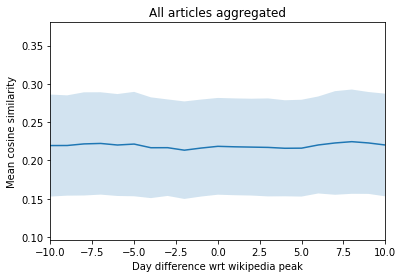

In [52]:
xvals = []
yvals = []
evalsplus = []
evalsminus = []
for ind in meantdcorrperart.index.values:
    xvals.append(ind)
    yvals.append(meantdcorrperart.loc[ind].mean())
    evalsplus.append(meantdcorrperart.loc[ind].mean()+meantdcorrperart.loc[ind].std())
    evalsminus.append(meantdcorrperart.loc[ind].mean()-meantdcorrperart.loc[ind].std())
# plot them

plt.plot(xvals,yvals)
plt.fill_between(xvals,evalsplus,evalsminus, alpha=0.2)
plt.xlim([-10,10])

plt.title('All articles aggregated')
plt.xlabel('Day difference wrt wikipedia peak')
plt.ylabel('Mean cosine similarity')
plt.show()